In [14]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Config
sns.set(color_codes=True)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [15]:
from useful_functions import *

## Score constituencies

In [16]:
ge10, ge15, ge17 = read_in_election_results() 

In [17]:
diff_17 = score_campaigns_difference(ge17, ge15)
uns_17 = score_campaigns_uns(ge17, ge15)
mrp_17 = score_campaigns_mrp(ge17)

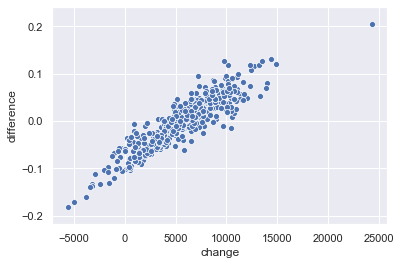

In [18]:
sns.scatterplot(diff_17['change'],uns_17['difference'])

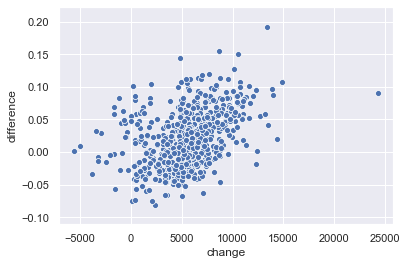

In [19]:
sns.scatterplot(diff_17['change'],mrp_17['difference'])

In [20]:
# this dataframe is just for reference
scores = pd.concat( [ge17['Constituency'],diff_17['change'],uns_17['difference'],mrp_17['difference'] ],
                    axis=1, verify_integrity=True, sort=True)
scores.columns = ['Constituency','diff','uns','mrp']
scores.sort_values('mrp',ascending=False).head(10)

,Constituency,diff,uns,mrp
E14000721,Hackney South and Shoreditch,13341.0,0.052593,0.192414
E14000581,Bootle,8640.0,-0.002234,0.155340
E14000760,Ilford South,10492.0,0.020187,0.150347
W07000070,Cynon Valley,4872.0,0.035253,0.144150
E14000801,Luton South,10144.0,0.084356,0.127369
E14000775,Knowsley,7723.0,-0.025753,0.120433
S14000024,Edinburgh South,6976.0,0.059651,0.118101
E14000732,Harrow West,8755.0,0.040875,0.113480
E14000679,East Ham,6561.0,-0.041637,0.113094
E14000687,Edmonton,5833.0,0.002643,0.112799


In [21]:
# seats that labour won by, or were within a certain percentage of winning
marginals = calc_marginal_within(0.10,ge17)

## Select demographic data to compare constituencies

In [22]:
census = read_in_census()
print(len(census))
# only want rows we have election data for
census = census.loc[ge17.index]
print(len(census))

650
631


In [23]:
features = ['c11PopulationDensity',
                'c11HouseOwned',
                'c11CarsNone',
                'c11EthnicityWhite',
                 'c11Unemployed',
                 'c11Retired',
                 'c11FulltimeStudent',
                 'c11Age65to74',
                 'c11DeprivedNone']

In [24]:
demographic_data = census[features]
print(len(demographic_data))
demographic_data = demographic_data.dropna()
print(len(demographic_data))

631
572


In [25]:
# a list of constituencies we have complete data for
constits_id = demographic_data.index
constits_name = [name_from_onsid(i,ge17) for i in constits_id]

constits_onsid_to_index = {onsid:i for i,onsid in enumerate(constits_id)}
constits_name_to_index = {name:i for i,name in enumerate(constits_name)}

## Calculate confidence that a local campaign was succesful

All constituencies are compared with each other.

We calculate the 'distance' between each constituency base on their demographics. Similar constituencies, based on the features chosen above' will have a small distance between them.

We then calculate the relative score between each campaign.

This score is divided by the distance for each constituency. Our confidence in this constituencies campaing is the sum of this value for all other constituencies.

If constituency A scored much better than constituency B, and they are very similar in demographics, A will recieve a positive contribution and B will recieve a negative one.

In [57]:
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances

def transform(x, cutoff):
    # beyond cutoff, constits are not counted
    mask = x <= cutoff
    x[mask] = cutoff - x[mask]
    notmask = np.invert(mask)
    x[notmask] = np.zeros(x.shape)[notmask]
    return x

def calc_significance_matrix(demographic_data, constit_score):
    X_scaled = preprocessing.scale(demographic_data)
    dist_matrix = pairwise_distances(X_scaled)
    dist_matrix = transform(dist_matrix,1)
    constit_score = preprocessing.scale(constit_score)
    score_matrix = constit_score[:,np.newaxis] - constit_score
    return score_matrix * dist_matrix
    #return np.divide(score_matrix, dist_matrix, where=dist_matrix!=0)
    
def calc_campaign_conf(demographic_data, constit_score):
    significance = calc_significance_matrix(demographic_data, constit_score)
    return pd.Series(np.sum(significance,1),index=demographic_data.index)

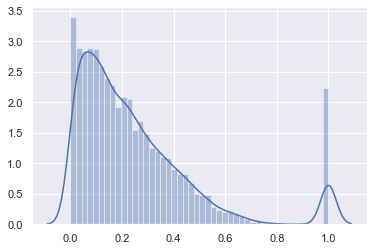

In [58]:
X_scaled = preprocessing.scale(demographic_data)
dist_matrix = pairwise_distances(X_scaled)
#sns.distplot(np.ndarray.flatten(dist_matrix))
t = transform(dist_matrix,1)
sns.distplot(t[np.where(t>0)])

In [59]:
diff = calc_campaign_conf(demographic_data, diff_17.loc[constits_id]['change'])
uns = calc_campaign_conf(demographic_data, uns_17.loc[constits_id]['difference'])
mrp = calc_campaign_conf(demographic_data, mrp_17.loc[constits_id]['difference'])

In [60]:
results = pd.DataFrame({'constituency': constits_name,
                        'diff': uns, 'uns': diff, 'mrp': mrp},
                       index = constits_id)
results.head(10)

,constituency,diff,uns,mrp
ons_id,,,,
E14000530,Aldershot,0.829518,0.310145,-0.112201
E14000531,Aldridge-Brownhills,-0.523448,-0.785523,-0.378702
E14000532,Altrincham and Sale West,2.302020,1.193421,4.205662
E14000533,Amber Valley,-11.306726,-12.921243,-8.139435
E14000534,Arundel and South Downs,2.049098,2.684053,0.941112
E14000535,Ashfield,-14.803544,-9.630296,-3.464885
E14000536,Ashford,2.683403,4.150125,10.077849
E14000537,Ashton-under-Lyne,0.413854,-0.234147,2.380070
E14000538,Aylesbury,3.379867,3.287462,2.808770


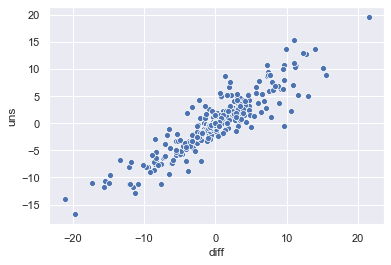

In [61]:
sns.scatterplot(x=results['diff'], y=results['uns'])

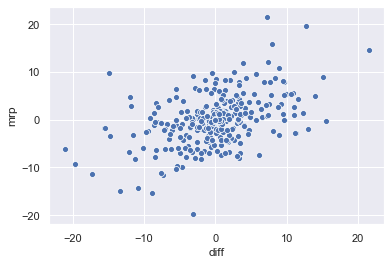

In [62]:
sns.scatterplot(x=results['diff'], y=results['mrp'])

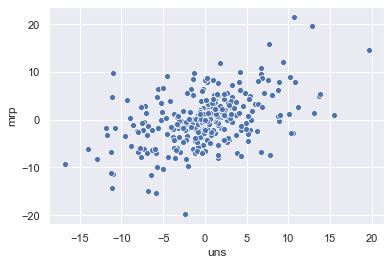

In [63]:
sns.scatterplot(x=results['uns'], y=results['mrp'])

In [64]:
results.sort_values('mrp',ascending=False).head()

,constituency,diff,uns,mrp
ons_id,,,,
E14000688,Ellesmere Port and Neston,7.242147,10.727501,21.572565
E14000623,Central Devon,12.765819,12.777993,19.666841
E14000624,Central Suffolk and North Ipswich,7.908518,7.623375,15.815468
E14000961,St Austell and Newquay,21.543050,19.638731,14.536837
E14000613,Bury St Edmunds,7.371443,9.387711,12.101473


In [69]:
pd.concat([results['constituency'],mrp_17['difference'],results['mrp']],axis=1,sort=False).sort_values('mrp',ascending=False)

,constituency,difference,mrp
E14000688,Ellesmere Port and Neston,0.082629,21.572565
E14000623,Central Devon,0.066656,19.666841
E14000624,Central Suffolk and North Ipswich,0.026343,15.815468
E14000961,St Austell and Newquay,0.056862,14.536837
E14000613,Bury St Edmunds,0.029254,12.101473
W07000054,Monmouth,0.028047,11.939928
E14000835,Newton Abbot,0.036224,10.937183
E14000536,Ashford,0.047934,10.077849
E14000791,Lichfield,0.031413,9.828934
E14000943,South Ribble,0.017168,9.743985


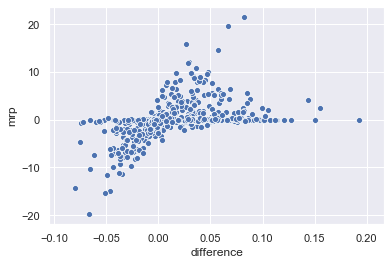

In [68]:
sns.scatterplot(mrp_17['difference'],results['mrp'])

1.425460293324188 Brigg and Goole
1.1116104246454444 North Shropshire
1.0779814412250883 Sherwood
0.9609656612774974 Amber Valley
0.830803497135722 Bassetlaw


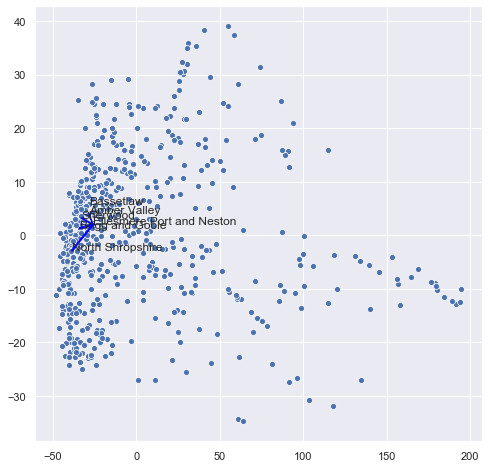

In [67]:
centre = 'Ellesmere Port and Neston'

significance_matrix = calc_significance_matrix(demographic_data, mrp_17.loc[constits_id]['difference'])
centre_i = constits_name_to_index[centre]
contributions = significance_matrix[centre_i]

# coi = constits of interest
coi   = [onsid_from_name(centre,ge17)]
linexs = []
lineys = []
values = []

N = 5
for i in np.flip(np.argsort(np.abs(contributions))[-N:]):
    onsid = demographic_data.index[i]
    coi += [onsid]
    values += [contributions[i]]
    print(contributions[i],name_from_onsid(onsid,ge17))

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE
embedding = Isomap(n_components=2)


X = demographic_data#[mask]
X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])

for c in coi:
    linexs += [ [x[centre_i],x[constits_onsid_to_index[c]] ] ]
    lineys += [ [y[centre_i],y[constits_onsid_to_index[c]] ] ]
    
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y)
#values = preprocessing.scale(values)
for linex,liney,value in zip(linexs,lineys,values):
    plt.plot(linex,liney,linewidth=value*2, color='blue')

val = pd.Series([name_from_onsid(i,ge17) for i in X.index])
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    
for c in coi:
    ax.text(x[constits_onsid_to_index[c]], y[constits_onsid_to_index[c]], name_from_onsid(c,ge17))
    #ax.text(point['x']+.001, point['y'], str(point['val']))

In [ ]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)

## Cluster

In [ ]:
from sklearn import cluster, covariance, manifold
from sklearn.cluster import AffinityPropagation

from sklearn import preprocessing
X = demographic_data
X_scaled = preprocessing.scale(X)

clustering = AffinityPropagation(verbose=True).fit(X)

In [ ]:
X = demographic_data.loc[marginals]
sizes = results['mrp'].loc[marginals]
sizes = np.array(sizes) - min(sizes)
hues = sizes
hues = list(pd.Series(clustering.labels_,index=results.index)[marginals])

#X = demographic_data
#sizes = results['mrp']

from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

#embedding = LocallyLinearEmbedding(n_components=2)
embedding = Isomap(n_components=2)
#embedding = SpectralEmbedding(n_components=2)
#embedding = MDS(n_components=2)

X_transformed = embedding.fit_transform(X)
x = pd.Series(X_transformed[:,0])
y = pd.Series(X_transformed[:,1])
val = pd.Series([name_from_onsid(i,ge17) for i in X.index])
val.index=range(len(X_transformed))

plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x,y=y,
                     size=sizes, sizes=(1, 1000),
                     hue=hues, palette='Set1')
a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x']+.001, point['y'], str(point['val']))


In [ ]:
sns.distplot(sizes)